Using device: cuda


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1/10 | Train Loss: 1.3774 | Train Acc: 0.7401 | Val Loss: 0.8907 | Val Acc: 1.0000
Epoch 2/10 | Train Loss: 0.6026 | Train Acc: 0.9525 | Val Loss: 0.4472 | Val Acc: 0.9341
Epoch 3/10 | Train Loss: 0.2326 | Train Acc: 0.9824 | Val Loss: 0.2592 | Val Acc: 0.9560
Epoch 4/10 | Train Loss: 0.1152 | Train Acc: 0.9882 | Val Loss: 0.3894 | Val Acc: 0.8901
Epoch 5/10 | Train Loss: 0.0622 | Train Acc: 0.9952 | Val Loss: 0.0873 | Val Acc: 0.9890
Epoch 6/10 | Train Loss: 0.0545 | Train Acc: 0.9909 | Val Loss: 0.0318 | Val Acc: 1.0000
Epoch 7/10 | Train Loss: 0.0232 | Train Acc: 0.9992 | Val Loss: 0.0390 | Val Acc: 0.9890
Epoch 8/10 | Train Loss: 0.0241 | Train Acc: 0.9965 | Val Loss: 0.1019 | Val Acc: 0.9670
Epoch 9/10 | Train Loss: 0.0266 | Train Acc: 0.9957 | Val Loss: 0.0577 | Val Acc: 0.9890
Epoch 10/10 | Train Loss: 0.0189 | Train Acc: 0.9971 | Val Loss: 0.1273 | Val Acc: 0.9670


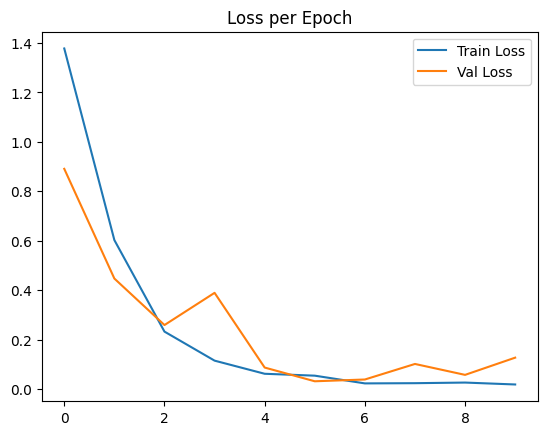

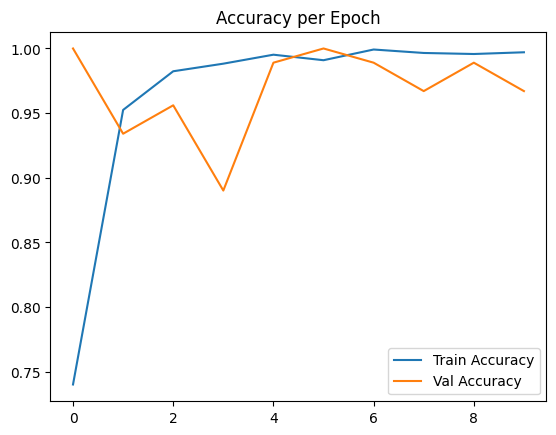

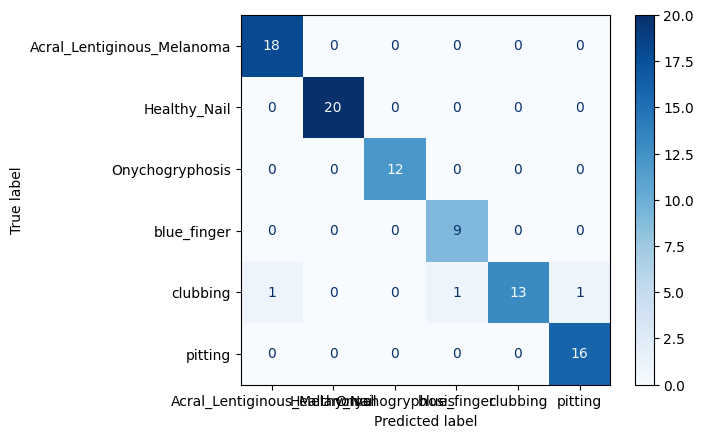

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.95      1.00      0.97        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       1.00      1.00      1.00        12
               blue_finger       0.90      1.00      0.95         9
                  clubbing       1.00      0.81      0.90        16
                   pitting       0.94      1.00      0.97        16

                  accuracy                           0.97        91
                 macro avg       0.96      0.97      0.96        91
              weighted avg       0.97      0.97      0.97        91

----- Model Summary Report -----
Model: ViT + LSTM Hybrid
Total Epochs: 10
Final Training Accuracy: 0.9971
Final Validation Accuracy: 0.9670


In [6]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset Path ===
data_dir = "E:/nail disease/Final Dataset"

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Load Dataset ===
train_data = ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

num_classes = len(train_data.classes)

# === ViT + LSTM Model ===
class ViT_LSTM_Model(nn.Module):
    def __init__(self, num_classes):
        super(ViT_LSTM_Model, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        vit_out = self.vit(pixel_values=x).last_hidden_state  # [B, 197, 768]
        lstm_out, _ = self.lstm(vit_out)                      # [B, 197, 256]
        final_out = self.fc(lstm_out[:, 0, :])                # Use [CLS] token output
        return final_out

# === Model Setup ===
model = ViT_LSTM_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

def calculate_accuracy(preds, labels):
    return (preds == labels).sum().item() / len(labels)

# === Training ===
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / len(train_data)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_data)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# === Visualization ===
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap='Blues')
plt.show()

# === Classification Report ===
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# === Summary ===
print("----- Model Summary Report -----")
print(f"Model: ViT + LSTM Hybrid")
print(f"Total Epochs: {epochs}")
print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc_list[-1]:.4f}")

Using device: cuda


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1/50 | Train Loss: 1.3669 | Train Acc: 0.7417 | Val Loss: 0.8807 | Val Acc: 0.9890
Epoch 2/50 | Train Loss: 0.5961 | Train Acc: 0.9613 | Val Loss: 0.3338 | Val Acc: 1.0000
Epoch 3/50 | Train Loss: 0.2430 | Train Acc: 0.9786 | Val Loss: 0.2496 | Val Acc: 0.9560
Epoch 4/50 | Train Loss: 0.1245 | Train Acc: 0.9861 | Val Loss: 0.2197 | Val Acc: 0.9560
Epoch 5/50 | Train Loss: 0.0780 | Train Acc: 0.9904 | Val Loss: 0.0752 | Val Acc: 0.9890
Epoch 6/50 | Train Loss: 0.0405 | Train Acc: 0.9963 | Val Loss: 0.0296 | Val Acc: 1.0000
Epoch 7/50 | Train Loss: 0.0364 | Train Acc: 0.9944 | Val Loss: 0.0639 | Val Acc: 0.9780
Epoch 8/50 | Train Loss: 0.0191 | Train Acc: 0.9989 | Val Loss: 0.0156 | Val Acc: 1.0000
Epoch 9/50 | Train Loss: 0.0217 | Train Acc: 0.9963 | Val Loss: 0.1300 | Val Acc: 0.9560
Epoch 10/50 | Train Loss: 0.0144 | Train Acc: 0.9981 | Val Loss: 0.1984 | Val Acc: 0.9560
Epoch 11/50 | Train Loss: 0.0113 | Train Acc: 0.9992 | Val Loss: 0.0823 | Val Acc: 0.9780
Epoch 12/50 | Train

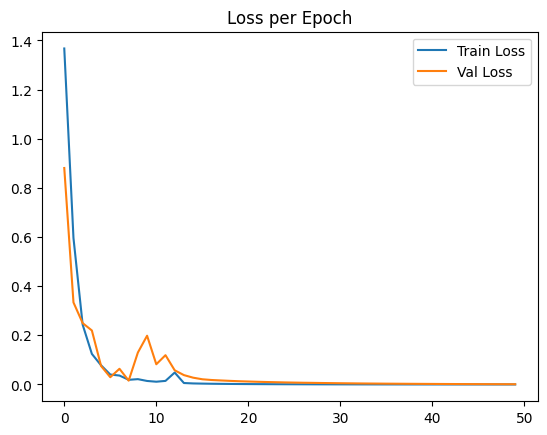

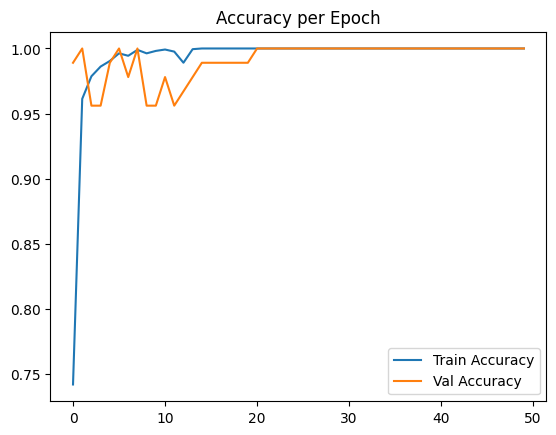

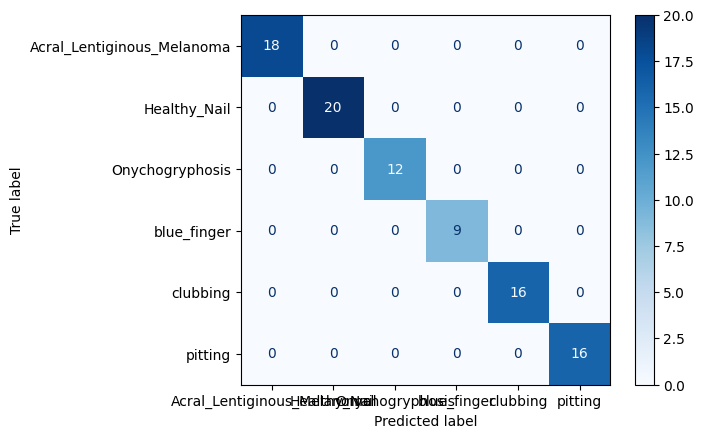

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       1.00      1.00      1.00        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       1.00      1.00      1.00        12
               blue_finger       1.00      1.00      1.00         9
                  clubbing       1.00      1.00      1.00        16
                   pitting       1.00      1.00      1.00        16

                  accuracy                           1.00        91
                 macro avg       1.00      1.00      1.00        91
              weighted avg       1.00      1.00      1.00        91

----- Model Summary Report -----
Model: ViT + LSTM Hybrid
Total Epochs: 50
Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000


In [7]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset Path ===
data_dir = "E:/nail disease/Final Dataset"

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Load Dataset ===
train_data = ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

num_classes = len(train_data.classes)

# === ViT + LSTM Model ===
class ViT_LSTM_Model(nn.Module):
    def __init__(self, num_classes):
        super(ViT_LSTM_Model, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        vit_out = self.vit(pixel_values=x).last_hidden_state  # [B, 197, 768]
        lstm_out, _ = self.lstm(vit_out)                      # [B, 197, 256]
        final_out = self.fc(lstm_out[:, 0, :])                # Use [CLS] token output
        return final_out

# === Model Setup ===
model = ViT_LSTM_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

def calculate_accuracy(preds, labels):
    return (preds == labels).sum().item() / len(labels)

# === Training ===
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / len(train_data)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_data)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# === Visualization ===
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap='Blues')
plt.show()

# === Classification Report ===
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# === Summary ===
print("----- Model Summary Report -----")
print(f"Model: ViT + LSTM Hybrid")
print(f"Total Epochs: {epochs}")
print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc_list[-1]:.4f}")

Using device: cuda


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1/10 | Train Loss: 1.0466 | Train Acc: 0.8058 | Val Loss: 0.3850 | Val Acc: 0.9341
Epoch 2/10 | Train Loss: 0.2285 | Train Acc: 0.9586 | Val Loss: 0.1387 | Val Acc: 0.9670
Epoch 3/10 | Train Loss: 0.1022 | Train Acc: 0.9818 | Val Loss: 0.0623 | Val Acc: 0.9890
Epoch 4/10 | Train Loss: 0.0598 | Train Acc: 0.9885 | Val Loss: 0.0281 | Val Acc: 1.0000
Epoch 5/10 | Train Loss: 0.0413 | Train Acc: 0.9915 | Val Loss: 0.0719 | Val Acc: 0.9780
Epoch 6/10 | Train Loss: 0.0157 | Train Acc: 0.9981 | Val Loss: 0.0657 | Val Acc: 0.9890
Epoch 7/10 | Train Loss: 0.0085 | Train Acc: 0.9997 | Val Loss: 0.0697 | Val Acc: 0.9890
Epoch 8/10 | Train Loss: 0.0067 | Train Acc: 0.9997 | Val Loss: 0.0334 | Val Acc: 0.9890
Epoch 9/10 | Train Loss: 0.0039 | Train Acc: 1.0000 | Val Loss: 0.0522 | Val Acc: 0.9890
Epoch 10/10 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0564 | Val Acc: 0.9890


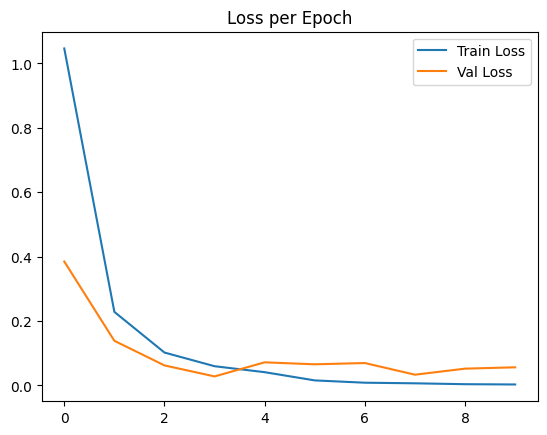

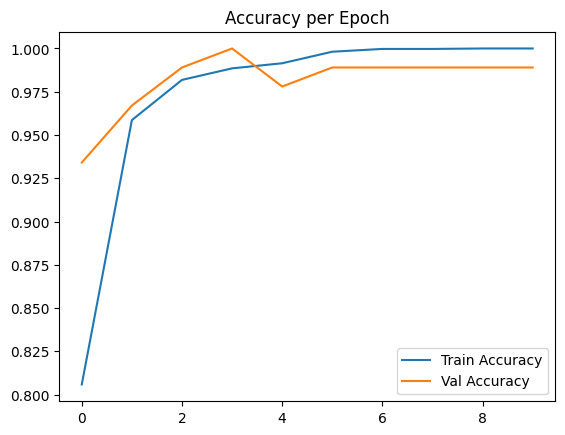

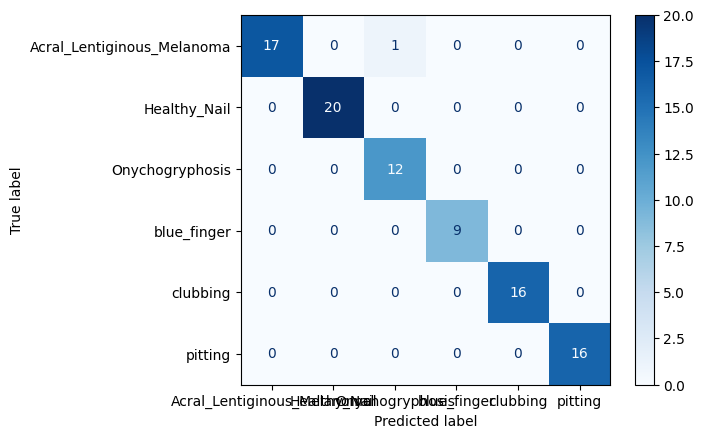

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       1.00      0.94      0.97        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       0.92      1.00      0.96        12
               blue_finger       1.00      1.00      1.00         9
                  clubbing       1.00      1.00      1.00        16
                   pitting       1.00      1.00      1.00        16

                  accuracy                           0.99        91
                 macro avg       0.99      0.99      0.99        91
              weighted avg       0.99      0.99      0.99        91

----- Model Summary Report -----
Model: ViT + BiLSTM Hybrid
Total Epochs: 10
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9890


In [8]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset Path ===
data_dir = "E:/nail disease/Final Dataset"

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Load Dataset ===
train_data = ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

num_classes = len(train_data.classes)

# === ViT + BiLSTM Model ===
class ViT_BiLSTM_Model(nn.Module):
    def __init__(self, num_classes):
        super(ViT_BiLSTM_Model, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.bilstm = nn.LSTM(input_size=768, hidden_size=256, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        vit_out = self.vit(pixel_values=x).last_hidden_state  # [B, 197, 768]
        lstm_out, _ = self.bilstm(vit_out)                   # [B, 197, 512]
        final_out = self.fc(lstm_out[:, 0, :])               # Use [CLS] token output
        return final_out

# === Model Setup ===
model = ViT_BiLSTM_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

def calculate_accuracy(preds, labels):
    return (preds == labels).sum().item() / len(labels)

# === Training ===
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / len(train_data)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_data)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# === Visualization ===
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap='Blues')
plt.show()

# === Classification Report ===
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# === Summary ===
print("----- Model Summary Report -----")
print(f"Model: ViT + BiLSTM Hybrid")
print(f"Total Epochs: {epochs}")
print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc_list[-1]:.4f}")


Using device: cuda


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1/50 | Train Loss: 1.0830 | Train Acc: 0.7698 | Val Loss: 0.3658 | Val Acc: 0.9670
Epoch 2/50 | Train Loss: 0.2393 | Train Acc: 0.9581 | Val Loss: 0.1461 | Val Acc: 0.9670
Epoch 3/50 | Train Loss: 0.0945 | Train Acc: 0.9829 | Val Loss: 0.1066 | Val Acc: 0.9780
Epoch 4/50 | Train Loss: 0.0559 | Train Acc: 0.9893 | Val Loss: 0.0571 | Val Acc: 0.9780
Epoch 5/50 | Train Loss: 0.0343 | Train Acc: 0.9941 | Val Loss: 0.0337 | Val Acc: 0.9890
Epoch 6/50 | Train Loss: 0.0216 | Train Acc: 0.9957 | Val Loss: 0.0099 | Val Acc: 1.0000
Epoch 7/50 | Train Loss: 0.0220 | Train Acc: 0.9957 | Val Loss: 0.1162 | Val Acc: 0.9560
Epoch 8/50 | Train Loss: 0.0225 | Train Acc: 0.9955 | Val Loss: 0.0456 | Val Acc: 0.9890
Epoch 9/50 | Train Loss: 0.0096 | Train Acc: 0.9992 | Val Loss: 0.0147 | Val Acc: 1.0000
Epoch 10/50 | Train Loss: 0.0039 | Train Acc: 1.0000 | Val Loss: 0.0213 | Val Acc: 0.9890
Epoch 11/50 | Train Loss: 0.0029 | Train Acc: 1.0000 | Val Loss: 0.0160 | Val Acc: 0.9890
Epoch 12/50 | Train

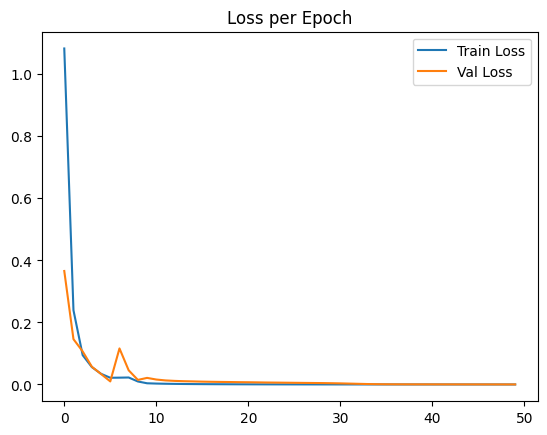

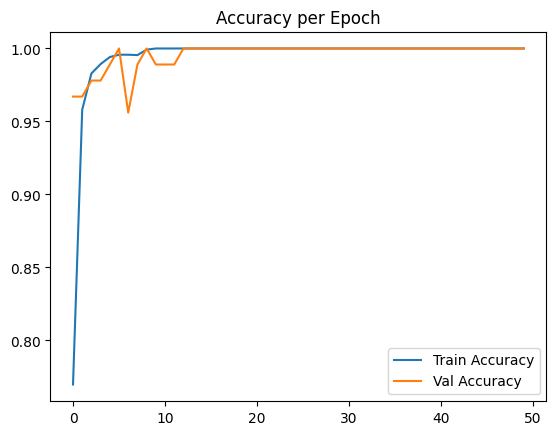

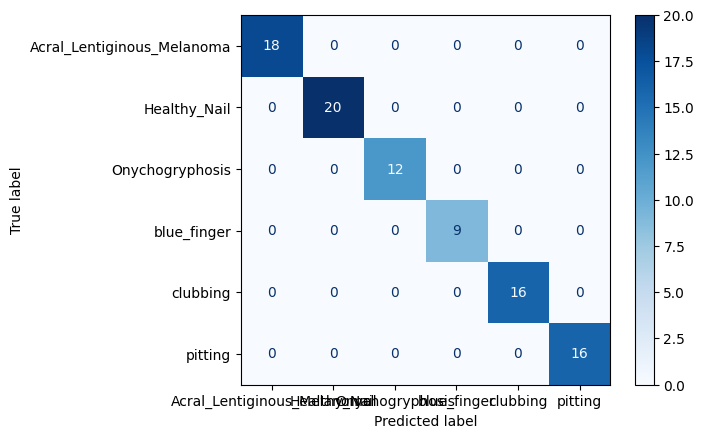

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       1.00      1.00      1.00        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       1.00      1.00      1.00        12
               blue_finger       1.00      1.00      1.00         9
                  clubbing       1.00      1.00      1.00        16
                   pitting       1.00      1.00      1.00        16

                  accuracy                           1.00        91
                 macro avg       1.00      1.00      1.00        91
              weighted avg       1.00      1.00      1.00        91

----- Model Summary Report -----
Model: ViT + BiLSTM Hybrid
Total Epochs: 50
Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000


In [9]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset Path ===
data_dir = "E:/nail disease/Final Dataset"

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Load Dataset ===
train_data = ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

num_classes = len(train_data.classes)

# === ViT + BiLSTM Model ===
class ViT_BiLSTM_Model(nn.Module):
    def __init__(self, num_classes):
        super(ViT_BiLSTM_Model, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.bilstm = nn.LSTM(input_size=768, hidden_size=256, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        vit_out = self.vit(pixel_values=x).last_hidden_state  # [B, 197, 768]
        lstm_out, _ = self.bilstm(vit_out)                   # [B, 197, 512]
        final_out = self.fc(lstm_out[:, 0, :])               # Use [CLS] token output
        return final_out

# === Model Setup ===
model = ViT_BiLSTM_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

def calculate_accuracy(preds, labels):
    return (preds == labels).sum().item() / len(labels)

# === Training ===
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / len(train_data)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_data)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# === Visualization ===
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap='Blues')
plt.show()

# === Classification Report ===
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# === Summary ===
print("----- Model Summary Report -----")
print(f"Model: ViT + BiLSTM Hybrid")
print(f"Total Epochs: {epochs}")
print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc_list[-1]:.4f}")
